In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

import deleon_berne as db

from tqdm import tqdm
from tqdm.auto import trange
import caffeine

import matplotlib.pylab as plt
import matplotlib.patches as patches
import matplotlib as mpl
from pylab import rcParams

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

In [3]:
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
plt.style.use('seaborn-white')

tick_labelsize = 15
axes_labelsize = 25
mpl.rcParams['xtick.labelsize'] = tick_labelsize
mpl.rcParams['ytick.labelsize'] = tick_labelsize
mpl.rcParams['axes.labelsize'] = axes_labelsize
mpl.rcParams['font.size'] = 20

output_filename = 'animations/'

### Frame by frame animation of a single trajectory in config. space, recording gap times

In [12]:
# Choose parameters and inital condition:

#             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
parameters = [8,   8,   1.5,  1.0,  1,  1/2**.5, 1,   10]
m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x= parameters

RelTol = 3.e-7
AbsTol = 1.e-7

x0 = [-0.08, 0, 0, 0]

trajectory_runtime = 10

# ------------------------------------------------------------------------------------------
# Calculate total energy:
energy_level = db.total_energy(x0, parameters)

N_times = int(trajectory_runtime * 100)
times = np.linspace(0, trajectory_runtime, N_times)

# Event function:

def event_func(t, x, *parameters):
    return x[1] # return y value

event_func.direction = 0
event_func.terminal = False

# Trajectory:

traj = solve_ivp(db.vector_field, t_span = [0,trajectory_runtime], y0 = x0, args = parameters,\
                events = event_func, rtol = RelTol, atol = AbsTol, dense_output = True)


event_times = traj.t_events[0]
trajectory = traj.sol.__call__(times)


# print(event_times)

In [21]:
# Text display function

def text_display(t):
    string = ''

    for j in range(1,len(event_times)):
        if t > event_times[j]:
            string += str(np.round(event_times[j] - event_times[j-1],1))+'\n'
        else:
            string += str(np.round(t - event_times[j-1],1))+'\n'
            break
    if t > event_times[-1]:
        string += str(np.round(t - event_times[-1],1))
    return string

# ------------------------------------------------------------------------------------------

def plot_everything(i, anim_speed):
    '''
    i = frame number
    '''

    # Bounding box and meshes:
    bb = db.config_bounding_box(parameters, energy_level)

    contour_res = 100
    x_mesh, y_mesh = np.meshgrid(np.linspace(bb[0],bb[1],contour_res), np.linspace(0,bb[3],contour_res))
    energy_mesh = db.total_energy([x_mesh, y_mesh, 0, 0], parameters)
    
    # ------------------------------------------------------------------------------------------
    
    # Plotting fixed stuff:

    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    ax = plt.axes(xlim=(bb[0],bb[1]), ylim=(bb[2],bb[3]))

    ax.scatter(x0[0],x0[1],c='r')
    ax.contour(x_mesh, y_mesh, energy_mesh, colors='black', levels = [energy_level])
    ax.contourf(x_mesh, y_mesh, energy_mesh, 100, cmap = "Greens",vmax = 1.7, \
                levels = np.linspace(np.min(energy_mesh),energy_level,20))
    ax.contour(x_mesh, -y_mesh, energy_mesh, colors='black', levels = [energy_level])
    ax.contourf(x_mesh, -y_mesh, energy_mesh, 100, cmap = "Reds",vmax = 1.7, \
                levels = np.linspace(np.min(energy_mesh),energy_level,20))
    ax.plot(np.linspace(-1/lamb*np.log(1+((energy_level - e_s)/D_x)**.5),\
                        -1/lamb*np.log(1-((energy_level - e_s)/D_x)**.5), 2), \
            [0,0], c='k', linestyle='dashed')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    fig.subplots_adjust(left = 0.1, right = 0.75)
    ax.text(0.11, 0.55, 'Reactant', c='g',transform=plt.gcf().transFigure)
    ax.text(0.12, 0.45, 'Product', c='r',transform=plt.gcf().transFigure)

    fig.suptitle("Example trajectory and gap times \n $\lambda = {}$".format(lamb)+', $\zeta = {}$'.format(zeta)\
                 +', $E={}$'.format(np.round(energy_level,2)))
    ax.text(0.78,0.85,'Gap times:', transform=plt.gcf().transFigure, va = 'top', weight='bold')
    
    rect1 = patches.Rectangle((0.75, 0.125), 0.2, 0.755, fc ='none', ec ='k', lw = 1, \
                              transform=plt.gcf().transFigure, clip_on = False)
    ax.add_patch(rect1) 
    
    # ------------------------------------------------------------------------------------------
    
    # Plotting time stuff:
        
    i = i*anim_speed
    t = times[i]
    i_trail = np.max([0,i - 30])
    if i == 0:
        ax.plot(x0[0], x0[1], 'bo')
    else:
        ax.plot(trajectory[0, i-1], trajectory[1, i-1], 'bo')
        
    ax.plot(trajectory[0,i_trail:i],trajectory[1,i_trail:i], c='k')
    ax.text(0.78,0.79, text_display(t), transform=plt.gcf().transFigure, va = 'top')
    return fig

In [22]:
# Create the images:
anim_speed = 6
N_frames = int(N_times/anim_speed)

with tqdm(total = N_frames) as pbar:
    for i in range(N_frames):
        fig = plot_everything(i, anim_speed)
        fig.savefig(output_filename+'frames/frame{0:0=4d}'.format(i))
        plt.close(fig)
        
        pbar.update(1)

100%|██████████| 1096/1096 [02:58<00:00,  6.14it/s]


In [16]:
def plot_everything2(i, anim_speed):

    bb = db.config_bounding_box(parameters, energy_level)

    contour_res = 100
    x_mesh, y_mesh = np.meshgrid(np.linspace(bb[0],bb[1],contour_res), np.linspace(0,bb[3],contour_res))
    energy_mesh = db.total_energy([x_mesh, y_mesh, 0, 0], parameters)

    # ------------------------------------------------------------------------------------------

    # Plotting fixed stuff:

    fig, ax = plt.subplots(1,1,figsize=(8, 10))
    ax = plt.axes(xlim=(bb[0],bb[1]), ylim=(bb[2],bb[3]))

    ax.scatter(x0[0],x0[1],c='r')
    ax.contour(x_mesh, y_mesh, energy_mesh, colors='black', levels = [energy_level])
    ax.contourf(x_mesh, y_mesh, energy_mesh, 100, cmap = "Greens",vmax = 1.7, \
                levels = np.linspace(np.min(energy_mesh),energy_level,20))
    ax.contour(x_mesh, -y_mesh, energy_mesh, colors='black', levels = [energy_level])
    ax.contourf(x_mesh, -y_mesh, energy_mesh, 100, cmap = "Reds",vmax = 1.7, \
                levels = np.linspace(np.min(energy_mesh),energy_level,20))
    ax.plot(np.linspace(-1/lamb*np.log(1+((energy_level - e_s)/D_x)**.5),\
                        -1/lamb*np.log(1-((energy_level - e_s)/D_x)**.5), 2), \
            [0,0], c='k', linestyle='dashed')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.text(0.15, 0.55, 'Reactant', c='g',transform=plt.gcf().transFigure)
    ax.text(0.16, 0.45, 'Product', c='r',transform=plt.gcf().transFigure)
    
    # ------------------------------------------------------------------------------------------
    
    # Plotting time stuff:
        
    i = i*anim_speed
    t = times[i]
    if i == 0:
        ax.plot(x0[0], x0[1], 'bo')
    else:
        ax.plot(trajectory[0, i-1], trajectory[1, i-1], 'bo')
    
    return fig

# Create the images:
anim_speed = 6
N_frames = int(N_times/anim_speed)

with tqdm(total = N_frames) as pbar:
    for i in range(N_frames):
        fig = plot_everything2(i, anim_speed)
        fig.savefig(output_filename+'frames/frame{0:0=4d}'.format(i))
        plt.close(fig)
        
        pbar.update(1)

100%|██████████| 166/166 [00:26<00:00,  6.31it/s]


## Animated trajectory of forward and backward dividing surfaces

In [55]:
#             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
parameters = [8,   8,   1.5,  1.0,  1,  1/2**.5, 1,   10]
energy_level = 1.02
N = 100

RelTol = 1e-7
AbsTol = 3e-7

x_PO, t_period_PO = db.UPO(parameters, energy_level, 100)
UPO_times = np.linspace(0, t_period_PO, 100)

init_points = db.forward_DS(N, parameters, energy_level, 20)

time_span = 200
frames_per_time = 5
traj_times = np.arange(0, time_span, 1/frames_per_time)

N_points = np.size(init_points, 0)
N_times = len(traj_times)


traj_points = np.zeros((N_points, 4, N_times))

for p in trange(N_points, smoothing = 0):
    init_state = init_points[p, :]
    traj = solve_ivp(db.vector_field, [0, time_span], init_state, args = parameters,\
                    dense_output = True, method='RK45', rtol=RelTol, atol=AbsTol)
    for t in range(N_times):
        traj_points[p, :, t] = traj.sol.__call__(traj_times[t])

In [58]:
N_times

1000

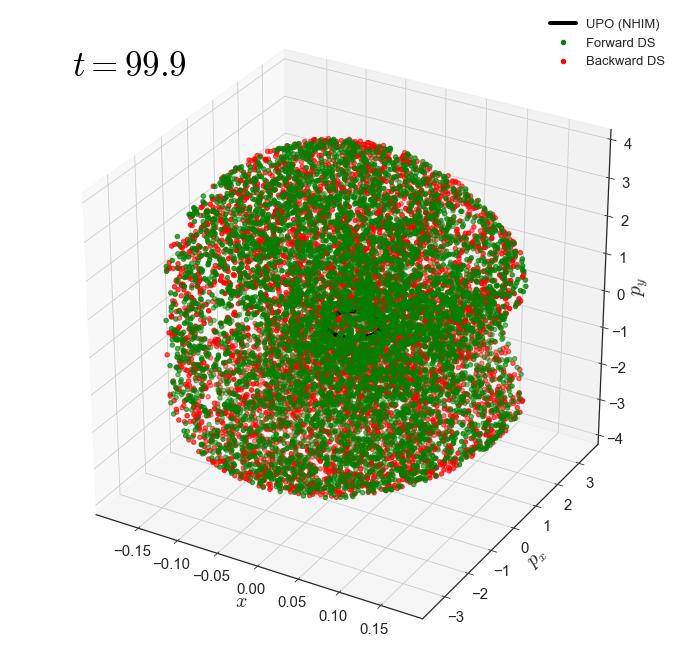

In [56]:
x_min,  x_max  = np.min(traj_points[:,0,:]), np.max(traj_points[:,0,:])
px_min, px_max = np.min(traj_points[:,2,:]), np.max(traj_points[:,2,:])
py_min, py_max = np.min(traj_points[:,3,:]), np.max(traj_points[:,3,:])

def plot_points(time, pts):
    
    fig = plt.figure(figsize = (12,12))
    axis_fs = 20
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.scatter(pts[:,0], pts[:,2], pts[:,3], c='g', label = 'Forward DS')
    ax.scatter(pts[:,0], pts[:,2], -pts[:,3], c='r', label = 'Backward DS')
    ax.plot(x_PO(UPO_times)[0,:], x_PO(UPO_times)[2,:], c='k', linewidth=4, label = 'UPO (NHIM)')
    
    ax.text2D(0.20, 0.80, s='$t={}$'.format(np.round(time, 1)), c='k',transform=plt.gcf().transFigure, fontsize = 35)

    ax.legend(fontsize=13)

    ax.set_xlabel('$x$', fontsize=axis_fs)
    ax.set_ylabel('$p_x$', fontsize=axis_fs)
    ax.set_zlabel('$p_y$', fontsize=axis_fs)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(px_min, px_max)
    ax.set_zlim(py_min, py_max)
    
    return fig, ax

fig, ax = plot_points(times[-1], traj_points[:, :, -1])
plt.show()

In [59]:
for t in trange(500):
    filename = output_filename + 'dance_frames/frame{0:0=4d}'.format(t)

    fig, ax = plot_points(times[t], traj_points[:, :, t])
    fig.savefig(filename)
    plt.close(fig)